In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn
%matplotlib inline

from matplotlib import rcParams
import matplotlib.ticker as ticker
rcParams.update({'figure.autolayout': True})

C:\Users\Zozi\Documents\rae\Python


Import data and split sample

In [9]:
##### from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
rs = 42


traore_data = pd.read_csv("../R project/Out/data_traore.csv")
ext_data_max = pd.read_csv("../R project/Out/data_extended_max.csv")
ext_data_sum = pd.read_csv("../R project/Out/data_extended_sum.csv")
trao_names = traore_data.columns

#Scale to 2010 USD
traore_data["adj_high_bid"]=traore_data["adj_high_bid"]/1.8975
ext_data_max["adj_high_bid"]=ext_data_max["adj_high_bid"]/1.8975
ext_data_sum["adj_high_bid"]=ext_data_sum["adj_high_bid"]/1.8975
#generate test and train indices
full_index=range(traore_data.shape[0])
train_ind,test_ind = train_test_split(full_index,test_size=0.2,random_state=rs)

#Traore 2018 dataset
X_trao = traore_data.drop("adj_high_bid",axis=1)
Y_trao = traore_data["adj_high_bid"]
#X_trao = pd.concat([X_trao, pd.get_dummies(traore_data['year'], prefix = 'year_')],axis=1)
X_trao = X_trao.drop(["multiple","asian_buyer","nordic_buyer","north_american_buyer","european_buyer","other_buyer"], axis=1)
X_trao = pd.concat([X_trao, pd.get_dummies(traore_data['country'], prefix = 'country_')],axis=1)



#Extended dataset
Y_Ext = ext_data_max["adj_high_bid"]
X_Ext_max = ext_data_max.drop("adj_high_bid",axis=1)
X_Ext_sum = ext_data_sum.drop("adj_high_bid",axis=1)

X_Ext_max = pd.concat([X_Ext_max, pd.get_dummies(traore_data['country'], prefix = 'country_')],axis=1)
X_Ext_max = X_Ext_max.drop(["multiple","asian_buyer","nordic_buyer","north_american_buyer","european_buyer","other_buyer","utz"], axis=1)
#X_Ext = X_Ext.drop(["rank1","rank2","rank3","rank4"],axis=1)
#X_Ext_max["relrank"] = pd.to_numeric(X_Ext_max["rank"].str.extract("(\d+)",expand=False))/X_Ext_max["ncoff"]

X_Ext_sum = pd.concat([X_Ext_sum, pd.get_dummies(traore_data['country'], prefix = 'country_')],axis=1)
X_Ext_sum = X_Ext_sum.drop(["multiple","asian_buyer","nordic_buyer","north_american_buyer","european_buyer","other_buyer","utz"], axis=1)
#X_Ext = X_Ext.drop(["rank1","rank2","rank3","rank4"],axis=1)
#X_Ext_sum["relrank"] = pd.to_numeric(X_Ext_sum["rank"].str.extract("(\d+)",expand=False))/X_Ext_sum["ncoff"]

X_trao = X_trao.drop(["scoresq","lnsize","year","country","matchID","rank","program","utz","lnprice",'lntrunc_min','trunc_min'],axis=1)
X_Ext_max = X_Ext_max.drop(["scoresq","lnsize","year","country","matchID","rank","program","lnprice"],axis=1)
X_Ext_sum = X_Ext_sum.drop(["scoresq","lnsize","year","country","matchID","rank","program","lnprice"],axis=1)


#Export summary statistics
pd.concat([Y_trao,X_trao], axis=1).describe().to_csv("C:/Users/Zozi/Documents/rae/Python/Out/desc_trao.csv")
pd.concat([Y_Ext,X_Ext_sum], axis=1).describe().to_csv("C:/Users/Zozi/Documents/rae/Python/Out/desc_ext.csv")
pd.concat([Y_Ext,X_Ext_max], axis=1).describe().to_csv("C:/Users/Zozi/Documents/rae/Python/Out/desc_ext_max.csv")


#Export final datasets
pd.concat([Y_trao,X_trao], axis=1).reset_index(drop=True).to_csv("C:/Users/Zozi/Documents/rae/Python/Out/Baseline.csv")
pd.concat([Y_Ext,X_Ext_sum], axis=1).reset_index(drop=True).to_csv("C:/Users/Zozi/Documents/rae/Python/Out/Cumulative.csv")
pd.concat([Y_Ext,X_Ext_max], axis=1).reset_index(drop=True).to_csv("C:/Users/Zozi/Documents/rae/Python/Out/Binary.csv")

X_trao = X_trao.drop(['country__Brazil','bourbon_variety','wet_proc'],axis=1)
X_Ext_max = X_Ext_max.drop(['country__Brazil','bourbon_variety','wet_proc'],axis=1)
X_Ext_sum = X_Ext_sum.drop(['country__Brazil','bourbon_variety','wet_proc'],axis=1)
Extbase_max = X_Ext_max
Extbase_sum = X_Ext_sum


#pca = PCA(n_components=5, svd_solver='auto')
#X_Ext = pd.concat([X_Ext,pd.DataFrame(pca.fit_transform(X_Ext.loc[:,levelcols]))],axis=1)
#print(pca.explained_variance_ratio_)


X_trao_names = X_trao.columns
scaler_trao = preprocessing.StandardScaler().fit(X_trao)
X_trao = pd.DataFrame(scaler_trao.transform(X_trao),columns=X_trao_names)


kf = KFold(n_splits=5, shuffle=True, random_state=rs^2)
i=0
train = list()
test = list()
for train_index, test_index in kf.split(np.array(traore_data.iloc[train_ind])):
    train.append(train_index)
    test.append(test_index)
    i += 1




**NEED TO RUN STATA SCRIPT BEFORE CONTINUING**

Set up 5-fold Cross-validation evaluation function

In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def cvlist():
    x=0
    while x < len(train):
        yield train[x],test[x]
        x += 1

def evalmodel(model,X,Y):
    cvs=cvlist()
    mae = -1*cross_val_score(model, X.iloc[train_ind], Y.iloc[train_ind], cv=cvs, scoring="neg_mean_absolute_error")
    cvs=cvlist()
    rmse = (-1*cross_val_score(model, X.iloc[train_ind], Y.iloc[train_ind], cv=cvs, scoring="neg_mean_squared_error"))**(1/2)
    return mae, rmse

def evaltest(model,X,Y):
    model.fit(X.iloc[train_ind],Y.iloc[train_ind])
    Y=Y.iloc[test_ind]
    y_pred=model.predict(X.iloc[test_ind])
    mae = mean_absolute_error(Y[test_ind],y_pred)
    rmse = mean_squared_error(Y[test_ind],y_pred,squared=False)
    return mae, rmse

    

In [4]:
from joblib import Parallel, delayed
import sklearn.linear_model as lm
import sklearn.tree as tree
from xgboost import XGBRegressor
from sklearn import ensemble as ens




models = dict()

#Linear models

cvs= cvlist()
models["Lasso"] = lm.Lasso(alpha=lm.LassoCV(cv=cvs).fit(X_trao.iloc[train_ind],Y_trao.iloc[train_ind]).alpha_)
cvs= cvlist()
models["Ridge"] = lm.Ridge(alpha=lm.RidgeCV(cv=cvs).fit(X_trao.iloc[train_ind],Y_trao.iloc[train_ind]).alpha_)

cvs= cvlist()
models["ElasticNet"] = lm.ElasticNet(alpha=lm.ElasticNetCV().fit(X_trao.iloc[train_ind],Y_trao.iloc[train_ind]).alpha_,l1_ratio=lm.ElasticNetCV(cv=cvs).fit(X_trao.iloc[train_ind],Y_trao.iloc[train_ind]).l1_ratio_)
models["OLS"] = lm.LinearRegression()


#Tree based algorithms
models["DecisionTree"] = tree.DecisionTreeRegressor(random_state=rs)
models["Random Forest"] = ens.RandomForestRegressor(n_jobs=3,random_state=rs)

#Other algorithms
models["GBReg"] = ens.GradientBoostingRegressor(random_state=rs)
models["Extratrees"] = ens.ExtraTreesRegressor(random_state=rs)
models["XGBoost"] = XGBRegressor(random_state=rs)


In [5]:
from joblib import Parallel, delayed

name_list = list()
model_list = list()

for name_m, model in models.items():
    name_list.append(name_m)
    model_list.append(model)
out=Parallel(n_jobs=-1,verbose=100)(delayed(evalmodel)(model,X_trao,Y_trao) for model in model_list)




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    4.2s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    4.2s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    4.4s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    5.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   12.2s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   14.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   27.6s finished


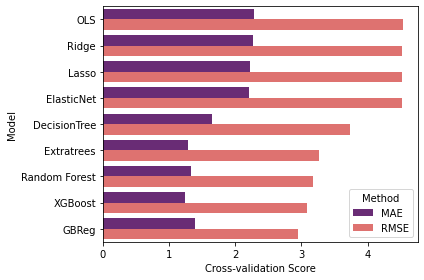

In [6]:
mae=pd.Series([1,2,3,4,5],name="Fold").reset_index(drop=True)
rmse=pd.Series([1,2,3,4,5],name="Fold").reset_index(drop=True)
results=dict()

for i in range(len(model_list)):
    results[name_list[i]]=out[i]

for name_m, tres in results.items():
    
    mae=pd.concat([mae.reset_index(drop=True), pd.Series(tres[0],name=name_m).reset_index(drop=True),],axis=1)
    rmse=pd.concat([rmse.reset_index(drop=True), pd.Series(tres[1],name=name_m).reset_index(drop=True)],axis=1)
    
#mae = pd.melt(mae)
mae = pd.melt(mae,id_vars="Fold")
mae.columns=["Fold","model","MAE"]
mae["MAE"] = pd.to_numeric(mae["MAE"])

rmse = pd.melt(rmse,id_vars="Fold")
#rmse = pd.melt(rmse)
rmse.columns=["Fold","model","RMSE"]
rmse["RMSE"] = pd.to_numeric(rmse["RMSE"])

ranking= rmse.groupby('model').mean().sort_values("RMSE", ascending=False)


res=mae.merge(rmse,on=["model","Fold"])
res = pd.melt(res,["model","Fold"])
res.columns=["model","Fold","method","score"]
ax= sns.barplot(y="model",x="score",hue="method",data=res, order=ranking.index,palette="magma",capsize=.2,ci=None)
ax.set(ylabel="Model",xlabel="Cross-validation Score")
ax.legend(title='Method')
plt.savefig("C:/Users/Zozi/Documents/rae/Python/Out/Default_models_trao.png",dpi=300)
plt.show()

Based on this, we can clearly conclude that tree-based ensemble methods outperform linear and SVR methods.

In [71]:
base_scores=res[res["method"]=="RMSE"].groupby(["model"]).mean().sort_values("score")

In [254]:
i=0
datasets=list()
for Extbase in (Extbase_sum,Extbase_max):
    datasets.append(dict())
    lvl1cols = Extbase.columns.str.contains("lvl1")
    pca1 = PCA(n_components="mle", svd_solver='auto')
    pcabase1 = pd.concat([Extbase,pd.DataFrame(pca1.fit_transform(Extbase.loc[:,lvl1cols]))],axis=1)
    pcadf1 = pd.DataFrame(pca1.fit_transform(Extbase.loc[:,lvl1cols]))
    pcadf1.columns=["pcalevel1"+str(i) for i in range(1, pcadf1.shape[1] + 1)]

    lvl2cols = Extbase.columns.str.contains("lvl2")
    pca2 = PCA(n_components="mle", svd_solver='auto')
    pcabase2 = pd.concat([Extbase,pd.DataFrame(pca2.fit_transform(Extbase.loc[:,lvl2cols]))],axis=1)
    pcadf2 = pd.DataFrame(pca2.fit_transform(Extbase.loc[:,lvl2cols]))
    pcadf2.columns=["pcalevel2"+str(i) for i in range(1, pcadf2.shape[1] + 1)]

    lvl3cols = Extbase.columns.str.contains("lvl3")
    pca3 = PCA(n_components="mle", svd_solver='auto')
    pcabase3 = pd.concat([Extbase,pd.DataFrame(pca3.fit_transform(Extbase.loc[:,lvl3cols]))],axis=1)
    pcadf3 = pd.DataFrame(pca3.fit_transform(Extbase.loc[:,lvl3cols]))
    pcadf3.columns=["pcalevel3"+str(i) for i in range(1, pcadf3.shape[1] + 1)]

    lvlcols = Extbase.columns.str.contains("lvl")
    pcalvl = PCA(n_components="mle", svd_solver='auto')
    pcabaselvl = pd.concat([Extbase,pd.DataFrame(pcalvl.fit_transform(Extbase.loc[:,lvlcols]))],axis=1)

    extracols = Extbase.columns.str.contains("lvl")
    pcaextra = PCA(n_components="mle", svd_solver='auto')
    pcabaseextra = pd.concat([Extbase,pd.DataFrame(pcaextra.fit_transform(Extbase.loc[:,extracols]))],axis=1)
    pcadfextra = pd.DataFrame(pca3.fit_transform(Extbase.loc[:,extracols]))
    pcadfextra.columns=["pcaext"+str(i) for i in range(1, pcadfextra.shape[1] + 1)]
    
    lvlextracols = Extbase.columns.str.contains("lvl|extra")
    pcalvlextra = PCA(n_components="mle", svd_solver='auto')
    pcalvlextra = pd.concat([Extbase,pd.DataFrame(pcalvlextra.fit_transform(Extbase.loc[:,lvlextracols]))],axis=1)
    
    pcabaselvl12 = pd.concat([Extbase,pd.DataFrame(pca3.fit_transform(Extbase.loc[:,lvl3cols]))])
    
    
    datasets[i]["Trao"]=X_trao
    datasets[i]["full"]=Extbase
    datasets[i]["lvl2"]=Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl1|lvl3")]
    datasets[i]["lvl3"]=Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl1|lvl2")]
    datasets[i]["lvl1_noext"]=Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl2|lvl3|extra")]
    datasets[i]["lvl2_noext"]=Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl1|lvl3|extra")]
    datasets[i]["lvl3_noext"]=Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl1|lvl2|extra")]
    datasets[i]["lvl1+lvl2pca"]=pcabase2.loc[:,~pcabase2.columns.to_series().astype(str).str.contains("lvl2|lvl3")]
    datasets[i]["lvl3+lvl2pca"]=pcabase2.loc[:,~pcabase2.columns.to_series().astype(str).str.contains("lvl2|lvl1")]
    datasets[i]["lvl1+lvl3pca"]=pcabase3.loc[:,~pcabase3.columns.to_series().astype(str).str.contains("lvl3|lvl2")]
    datasets[i]["lvl2+lvl3pca"]=pcabase3.loc[:,~pcabase3.columns.to_series().astype(str).str.contains("lvl3|lvl1")]
    datasets[i]["lvl1pca"]=pcabase1.loc[:,~pcabase1.columns.to_series().astype(str).str.contains("lvl")]
    datasets[i]["lvl2pca"]=pcabase2.loc[:,~pcabase2.columns.to_series().astype(str).str.contains("lvl")]
    datasets[i]["lvl3pca"]=pcabase3.loc[:,~pcabase3.columns.to_series().astype(str).str.contains("lvl")]
    datasets[i]["lvl1pca_noext"]=pcabase1.loc[:,~pcabase1.columns.to_series().astype(str).str.contains("lvl|extra")]
    datasets[i]["lvl2pca_noext"]=pcabase2.loc[:,~pcabase2.columns.to_series().astype(str).str.contains("lvl|extra")]
    datasets[i]["lvl3pca_noext"]=pcabase3.loc[:,~pcabase3.columns.to_series().astype(str).str.contains("lvl|extra")]
    datasets[i]["fulllvlpca"]=pcabaselvl.loc[:,~pcabaselvl.columns.to_series().astype(str).str.contains("lvl")]
    datasets[i]["fulllvlpca_noext"]=pcabaselvl.loc[:,~pcabaselvl.columns.to_series().astype(str).str.contains("lvl|extra")]
    datasets[i]["extrapca-nolevel"]=pcabaseextra.loc[:,~pcabaseextra.columns.to_series().astype(str).str.contains("extra|lvl")]
    datasets[i]["extrapca-lvl1"]=pcabaseextra.loc[:,~pcabaseextra.columns.to_series().astype(str).str.contains("extra|lvl2|lvl3")]
    datasets[i]["extrapca-lvl2"]=pcabaseextra.loc[:,~pcabaseextra.columns.to_series().astype(str).str.contains("extra|lvl1|lvl3")]
    datasets[i]["extrapca-lvl3"]=pcabaseextra.loc[:,~pcabaseextra.columns.to_series().astype(str).str.contains("extra|lvl2|lvl1")]
    datasets[i]["fullpca"]=pcalvlextra.loc[:,~pcalvlextra.columns.to_series().astype(str).str.contains("extra|lvl")]
    datasets[i]["lvl1pca+lvl2pca"]=pd.concat([Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl")],pcadf1,pcadf2],axis=1)
    datasets[i]["lvl3pca+lvl2pca"]=pd.concat([Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl")],pcadf2,pcadf3],axis=1)
    datasets[i]["lvl1pca+lvl3pca"]=pd.concat([Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl")],pcadf1,pcadf3],axis=1)
    datasets[i]["allseplvlpca"]=pd.concat([Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl")],pcadf1,pcadf2,pcadf3],axis=1)
    datasets[i]["allsepfullpca"]=pd.concat([Extbase.loc[:,~Extbase.columns.to_series().astype(str).str.contains("lvl|extra")],pcadf1,pcadf2,pcadf3,pcadfextra],axis=1)
    datasets[i]["lvl1pca+extpca"]=pd.concat([pcabase1.loc[:,~pcabase1.columns.to_series().astype(str).str.contains("lvl|extra")],pcadfextra],axis=1)
    datasets[i]["lvl2pca+extpca"]=pd.concat([pcabase2.loc[:,~pcabase2.columns.to_series().astype(str).str.contains("lvl|extra")],pcadfextra],axis=1)
    datasets[i]["lvl3pca+extpca"]=pd.concat([pcabase3.loc[:,~pcabase3.columns.to_series().astype(str).str.contains("lvl|extra")],pcadfextra],axis=1)
    i+=1
ogsets=datasets
for ind, dset in datasets[0].items():
    xnames=dset.columns
    scaler_x = preprocessing.StandardScaler().fit(dset)
    datasets[0][ind] = pd.DataFrame(scaler_x.transform(dset),columns=xnames)
for ind, dset in datasets[1].items():
    xnames=dset.columns
    scaler_x = preprocessing.StandardScaler().fit(dset)
    if ind =="lvl1_noext": winscaler=scaler_x
    datasets[1][ind] = pd.DataFrame(scaler_x.transform(dset),columns=xnames)

In [73]:
models2=dict()
models2["Random Forest"] = ens.RandomForestRegressor(n_jobs=3,random_state=rs)
models2["GBReg"] = ens.GradientBoostingRegressor(random_state=rs)
models2["Extratrees"] = ens.ExtraTreesRegressor(random_state=rs,n_jobs=6)
models2["XGBoost"] = XGBRegressor(n_jobs=3,random_state=rs)
#models2["OptXGBoost"] = XGBRegressor(subsample= 0.8,
# reg_lambda= 1.2,
# gamma= 0.5,
# n_estimators= 200,
# max_depth= 6,
# colsample_bytree= 1,
# learning_rate= 0.25,
# reg_alpha= 0.1, n_jobs=3)

mnames=list()
for key, model in models2.items():
    mnames.append(key)

In [74]:
### ModelxDataset permutations
mxdresults_sum=dict()
for m_key, model in models2.items():
    mxdresults_sum[m_key] = dict()
    for key, X_set in datasets[0].items():
        output=evalmodel(model,X_set,Y_Ext)
        mxdresults_sum[m_key][key]=dict()
        mxdresults_sum[m_key][key]["dataset"]=X_set
        mxdresults_sum[m_key][key]["MAE"]=output[0]
        mxdresults_sum[m_key][key]["RMSE"]=output[1]

mxdresults_max=dict()
for m_key, model in models2.items():
    mxdresults_max[m_key] = dict()
    for key, X_set in datasets[1].items():
        output=evalmodel(model,X_set,Y_Ext)
        mxdresults_max[m_key][key]=dict()
        mxdresults_max[m_key][key]["dataset"]=X_set
        mxdresults_max[m_key][key]["MAE"]=output[0]
        mxdresults_max[m_key][key]["RMSE"]=output[1]

%store mxdresults_max
%store mxdresults_sum

Stored 'mxdresults_max' (dict)
Stored 'mxdresults_sum' (dict)


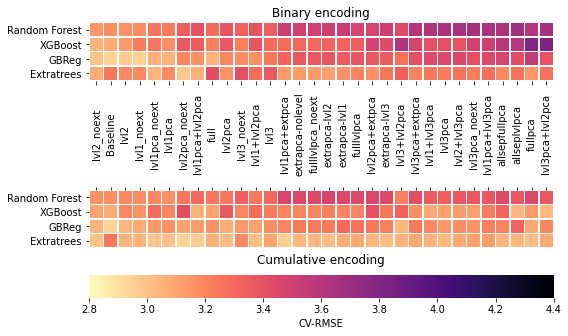

Stored 'mxddf' (DataFrame)
Stored 'mxddf_m' (DataFrame)


In [133]:
###get results into table form
%store -r mxdresults_max
%store -r mxdresults_sum


mxddf_m=pd.DataFrame(index=list(datasets[1].keys()))
for m_key, sets in mxdresults_max.items():
    mxddf_m=pd.concat([mxddf_m,pd.DataFrame.from_dict(sets).transpose()["RMSE"]],axis=1)
    prev_cols=list(mxddf_m.columns)
    prev_cols[-1]=m_key
    mxddf_m.columns=prev_cols
    
mxddf_m = mxddf_m.applymap(np.mean)
mxddf_m["means"]=mxddf_m.mean(axis=1)
mxddf_m=mxddf_m.sort_values("means").drop("means",axis=1)
mxddf_m=mxddf_m.reindex(mxddf_m.mean().sort_values(ascending=False).index, axis=1)



mxddf=pd.DataFrame(index=list(datasets[0].keys()))
for m_key, sets in mxdresults_sum.items():
    mxddf=pd.concat([mxddf,pd.DataFrame.from_dict(sets).transpose()["RMSE"]],axis=1)
    prev_cols=list(mxddf.columns)
    prev_cols[-1]=m_key
    mxddf.columns=prev_cols
    
mxddf = mxddf.applymap(np.mean)
mxddf["means"]=mxddf.mean(axis=1)
mxddf=mxddf.reindex(mxddf_m.index,axis=0)
mxddf=mxddf.reindex(mxddf_m.mean().sort_values(ascending=False).index, axis=1)







#plt.figure(num=None, figsize=(8, 4), dpi=300, facecolor='w', edgecolor='k')
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
sns.heatmap(mxddf_m.transpose().rename({"Trao":"Baseline"},axis=1),ax=ax1,cmap="magma_r",square=True,linewidths=.5,cbar=False,vmin=2.8,vmax=4.4)
sns.heatmap(mxddf.transpose().rename({"Trao":"Baseline"},axis=1),ax=ax2,cmap="magma_r",square=True,linewidths=.5,cbar_kws={"orientation": "horizontal","pad":0.1,"label":"CV-RMSE"},vmin=2.8,vmax=4.4)
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax1.set_title("Binary encoding")
ax2.set_title("Cumulative encoding",y=-0.375)
plt.sca(ax2)
plt.xticks(rotation=90,verticalalignment="center",position=(0,1.85))


plt.savefig("C:/Users/Zozi/Documents/rae/Python/Out/mxd_max.png",dpi=300)
plt.show()
%store mxddf
%store mxddf_m

In [132]:
mxddf_m

,Random Forest,XGBoost,GBReg,Extratrees
lvl2_noext,3.154682,3.054534,2.993769,3.079867
Trao,3.180078,3.084742,2.945957,3.261050
lvl2,3.171099,3.137116,2.972129,3.193362
lvl1_noext,3.177756,3.237553,2.950197,3.192106
lvl1pca_noext,3.263255,3.260782,3.059528,3.054497
lvl1pca,3.242473,3.179356,3.057969,3.183771
lvl2pca_noext,3.346343,3.367504,3.211092,2.984212
lvl1pca+lvl2pca,3.403548,3.351060,3.164264,3.067705
full,3.287600,3.225573,3.052166,3.421771
lvl2pca,3.383192,3.379104,3.205298,3.163528


Now exploring of dropping variables for the top models can further improve performance.

First choose the top 10% of models: (Note this gets rid of random forests)

In [83]:
%store -r mxddf
%store -r mxddf_m


mxddf=mxddf.drop("Trao",axis=0)
mxddf_m=mxddf_m.drop("Trao",axis=0)
threshold = np.percentile(pd.concat([mxddf,mxddf_m], axis=1),1.75) 
perc25 = np.percentile(pd.concat([mxddf,mxddf_m], axis=1),1.75)
perc75 = np.percentile(pd.concat([mxddf,mxddf_m], axis=1),50)
selected = dict()
selected["sum"]=mxddf<=threshold
selected["max"]=mxddf_m<=threshold
combinations = dict()
combinations["sum"] = dict()
combinations["max"] = dict()
for col in selected["sum"]:
    if np.sum(selected["sum"][col])>0:
        combinations["sum"][col]=selected["sum"].index[selected["sum"][col]].tolist()
for col in selected["max"]:
    if np.sum(selected["max"][col])>0:
        combinations["max"][col]=selected["max"].index[selected["max"][col]].tolist()

        
selected = dict()
selected["sum"]=(mxddf<=perc75)&(mxddf>=perc25)
selected["max"]=(mxddf_m<=perc75)&(mxddf_m>=perc25)
mid_sample = dict()
mid_sample["sum"] = dict()
mid_sample["max"] = dict()
for col in selected["sum"]:
    if np.sum(selected["sum"][col])>0:
        mid_sample["sum"][col]=selected["sum"].index[selected["sum"][col]].tolist()
for col in selected["max"]:
    if np.sum(selected["max"][col])>0:
        mid_sample["max"][col]=selected["max"].index[selected["max"][col]].tolist()


In [84]:
import random
random.seed(rs*5)
extracombs=pd.DataFrame(mid_sample).applymap(lambda x: random.sample(x,k=1)[0])
extracombs["max"]=extracombs["sum"]

In [85]:
combinations

{'sum': {'Extratrees': ['lvl2pca_noext', 'lvl1pca+lvl2pca', 'lvl1pca+extpca']},
 'max': {'GBReg': ['lvl2', 'lvl1_noext']}}

In [86]:
extracombs

,sum,max
Random Forest,lvl1pca_noext,lvl1pca_noext
XGBoost,lvl2_noext,lvl2_noext
GBReg,fullpca,fullpca
Extratrees,lvl1pca+lvl3pca,lvl1pca+lvl3pca


In [87]:
import re

defaultres=dict()
for key in combinations.keys():
    for m_key in combinations[key].keys():
        for setkey in combinations[key][m_key]:
                if (key=="sum"):
                    defaultres["{}_{}_{}".format(m_key,"sum",setkey)]=mxddf.loc[setkey,m_key]
                else:
                    defaultres["{}_{}_{}".format(m_key,"max",setkey)]=mxddf_m.loc[setkey,m_key]
for m_key, row in extracombs.iterrows():
    defaultres["{}_{}_{}".format(m_key,"sum",row["sum"])]=mxddf.loc[row["sum"],m_key]
    defaultres["{}_{}_{}".format(m_key,"max",row["max"])]=mxddf_m.loc[row["max"],m_key]


defaultres


{'Extratrees_sum_lvl2pca_noext': 2.953793539183086,
 'Extratrees_sum_lvl1pca+lvl2pca': 2.96964546725583,
 'Extratrees_sum_lvl1pca+extpca': 2.9655188146722753,
 'GBReg_max_lvl2': 2.972129390616413,
 'GBReg_max_lvl1_noext': 2.9501974400031363,
 'Random Forest_sum_lvl1pca_noext': 3.20346956423039,
 'Random Forest_max_lvl1pca_noext': 3.26325513389853,
 'XGBoost_sum_lvl2_noext': 3.1096593951865446,
 'XGBoost_max_lvl2_noext': 3.0545340375116856,
 'GBReg_sum_fullpca': 3.0875385624912104,
 'GBReg_max_fullpca': 3.555389308175988,
 'Extratrees_sum_lvl1pca+lvl3pca': 3.1302331723260823,
 'Extratrees_max_lvl1pca+lvl3pca': 3.2828504809678685}

In [88]:
from skopt.space import Real, Integer, Categorical
#Reset models
models3= dict()
models3["Random Forest"] = ens.RandomForestRegressor
models3["GBReg"] = ens.GradientBoostingRegressor
models3["Extratrees"] = ens.ExtraTreesRegressor
models3["XGBoost"] = XGBRegressor

spaces=dict()
spacenames = dict()

spacenames["XGBoost"] = ["max_depth","n_estimators","gamma","reg_alpha","reg_lambda","subsample","learning_rate"]
spaces["XGBoost"] = [Integer(name="max_depth",low=2,high=12),
             Integer(name="n_estimators",low=200,high=600),
             Real(name="gamma",low=0.4,high=0.85),
             Real(name="reg_alpha",low=0.05,high=0.65),
             Real(name="reg_lambda",low=0.75,high=1),
             Real(name="subsample",low=0.75,high=1),
             Real(name="learning_rate",low=0.025,high=0.3)]

spacenames["Extratrees"] = ["max_depth","n_estimators","max_samples","min_samples_split","min_samples_leaf"]
spaces["Extratrees"] = [Integer(name="max_depth",low=2,high=35),
             Integer(name="n_estimators",low=100,high=1000),
             Real(name="max_samples",low=0.7,high=1),
             Integer(name="min_samples_split",low=2,high=30),
             Integer(name="min_samples_leaf",low=1,high=5)]

spacenames["GBReg"] = ["max_depth","n_estimators","subsample","max_features","min_samples_split","learning_rate","alpha"]
spaces["GBReg"] = [Integer(name="max_depth",low=2,high=8),
             Integer(name="n_estimators",low=200,high=1000),
             Real(name="subsample",low=0.9,high=1),
             Integer(name="max_features",low=2,high=39),
             Integer(name="min_samples_split",low=2,high=40),
             Real(name="learning_rate",low=0.005,high=0.2),
             Real(name="alpha",low=0.75,high=0.975)]

spacenames["Random Forest"] = ["max_depth","n_estimators","max_samples","min_samples_split","bootstrap","min_samples_leaf"]
spaces["Random Forest"] = [Integer(name="max_depth",low=2,high=35),
             Integer(name="n_estimators",low=100,high=1000),
             Real(name="max_samples",low=0.7,high=1),
             Integer(name="min_samples_split",low=2,high=30),
             Categorical(name="bootstrap",categories=[False,True]),
             Integer(name="min_samples_leaf",low=1,high=5)]




In [89]:
from skopt import forest_minimize
from skopt.utils import use_named_args
from functools import partial



def compare_opts(model,dset,dimensions,n_calls,minimizer,n_iter=1):
    reg=model()
    @use_named_args(dimensions)
    def objective(**kwargs): 
        if (model==models3["GBReg"]):
            reg.set_params(random_state=rs,**kwargs)
        else:
            reg.set_params(random_state=rs,n_jobs=3,**kwargs)
        output=evalmodel(reg,dset,Y_Ext)
        return np.mean(output[1])
    
    
    
    
    res = [minimizer(objective, dimensions, n_calls=n_calls, random_state=n) for n in range(n_iter)]
    return res

In [91]:
itercands = ["XGBoost","Extratrees","GBReg", "Random Forest"]
iterres=dict()
for itcand in itercands:
    iterres[itcand] = compare_opts(minimizer=partial(forest_minimize, base_estimator="ET"),model=models3[itcand],dset=datasets[1]["lvl2"],n_calls=150, dimensions=spaces[itcand])
    print(itcand+" finished")


XGBoost finished
Extratrees finished
GBReg finished
Random Forest finished


In [92]:

iterscores=dict()
for itcand in itercands:
    iterscores[itcand]=dict()
    iterscores[itcand]["CVscores"]=iterres[itcand][0].func_vals
    params=[dict(zip(spacenames[itcand],x)) for x in iterres[itcand][0].x_iters]
    iterscores[itcand]["testscores"]=[evaltest(models3[itcand](random_state=rs,**param),datasets[1]["Trao"],Y_Ext)[1] for param in params]
    iterscores[itcand]["mintestrmse"]=list()
    iterscores[itcand]["mincvscore"]=list()
    iterscores[itcand]["acttestrmse"]=list()
    for i in range(150):
        iterscores[itcand]["mintestrmse"].append(min(iterscores[itcand]["testscores"][0:i+1]))
        iterscores[itcand]["mincvscore"].append(min(iterscores[itcand]["CVscores"][0:i+1]))
        val, idx = min((val, idx) for (idx, val) in enumerate(iterscores[itcand]["CVscores"][0:i+1]))
        iterscores[itcand]["acttestrmse"].append(iterscores[itcand]["testscores"][idx])


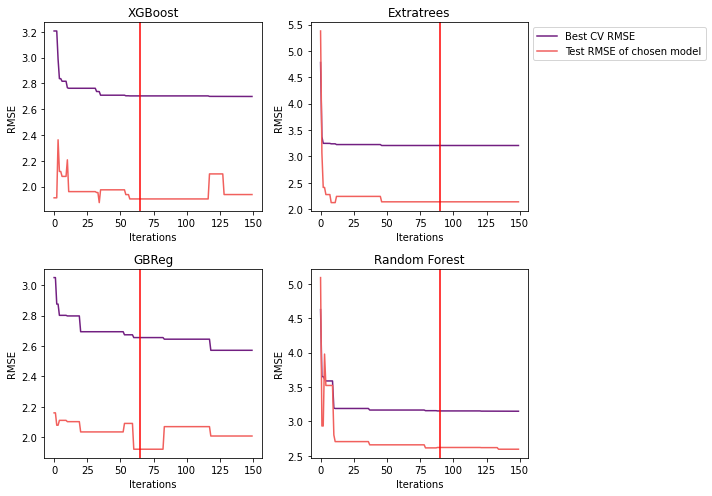

In [136]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
i=0
j=0
jinc=True

for name, row in pd.DataFrame(iterscores).transpose().iterrows():
    cvfit=pd.concat([pd.Series(row["mincvscore"],name="Best CV RMSE"),pd.Series(row["acttestrmse"],name="Test RMSE of chosen model"),pd.Series(range(150),name="Iterations")],axis=1)
    cvfit=pd.melt(cvfit,"Iterations")
    if i==0 and j==1:
        leg=True
    else:
        leg=False
    
    
    cvfit.columns = ["Iterations","Score type","RMSE"]
    sns.lineplot(data=cvfit,y="RMSE",x="Iterations",hue="Score type",palette="magma",ax=ax[i][j],legend=leg)
    n=90
    if (name in ["XGBoost","GBReg"]): n=65
    ax[i][j].axvline(x=n,color="red")
    ax[i][j].set_title(name)
    if i==0 and j==1:
        ax[i][j].legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    
    
    if jinc==True:
        jinc=False
        j+=1
    else:
        jinc=True
        j-=1
        i+=1
    
    
    

plt.savefig("Out/optimisation.png",dpi=300)  
   


In [99]:
base_reses=dict()
cands=["XGBoost","Extratrees","GBReg","Random Forest"]
for cand in cands:
    n=90
    if (cand in ["XGBoost","GBReg"]): n=65
    base_reses[cand+"_trao_opt"]=compare_opts(minimizer=partial(forest_minimize, base_estimator="ET"),model=models3[cand],dset=X_trao,n_calls=n, dimensions=spaces[cand])
    print(cand+" finished")

XGBoost finished
Extratrees finished
GBReg finished
Random Forest finished


In [100]:
testres = dict()
testcands = ["OLS","XGBoost","Extratrees","GBReg", "Random Forest"]

for cand, res in base_reses.items():
    m=re.search("^([a-zA-Z\s]+)_.+",cand)
    testres[cand]=evaltest(models3[m.group(1)](**dict(zip(spacenames[m.group(1)],res[0].x))),X_trao,Y_Ext)

testres

{'XGBoost_trao_opt': (1.1353122030382994, 2.0888112528679104),
 'Extratrees_trao_opt': (1.2279690893091069, 2.2251146079721504),
 'GBReg_trao_opt': (1.1111054881839548, 2.1641132754608723),
 'Random Forest_trao_opt': (1.2906979801405718, 2.7180515440222504)}

In [101]:
reses=dict()
for ind, row in pd.DataFrame(combinations).iterrows():
    n=90
    if (ind in ["XGBoost","GBReg"]): n=65
    if(row[["sum"]].isna()["sum"]):
        ismax=True
        for dset in row["max"]:
            reses["{}_{}_{}".format(ind,"max",dset)]=compare_opts(minimizer=partial(forest_minimize, base_estimator="ET"),model=models3[ind],dset=datasets[ismax][dset],n_calls=n, dimensions=spaces[ind])
            print("{}_{}_{}".format(ind,"max",dset)+" finished")
    else:
        ismax=False
        for dset in row["sum"]:
            reses["{}_{}_{}".format(ind,"sum",dset)]=compare_opts(minimizer=partial(forest_minimize, base_estimator="ET"),model=models3[ind],dset=datasets[ismax][dset],n_calls=n, dimensions=spaces[ind])
            print("{}_{}_{}".format(ind,"sum",dset)+" finished")

Extratrees_sum_lvl2pca_noext finished
Extratrees_sum_lvl1pca+lvl2pca finished
Extratrees_sum_lvl1pca+extpca finished
GBReg_max_lvl2 finished
GBReg_max_lvl1_noext finished


In [102]:
for ind, row in extracombs.iterrows():
    n=90
    if (ind in ["XGBoost","GBReg"]): n=65
    reses["{}_{}_{}".format(ind,"sum",row["sum"])]=compare_opts(minimizer=partial(forest_minimize, base_estimator="ET"),model=models3[ind],dset=datasets[0][row["sum"]],n_calls=n, dimensions=spaces[ind])
    print("{}_{}_{}".format(ind,"sum",row["sum"])+" finished")
    reses["{}_{}_{}".format(ind,"max",row["max"])]=compare_opts(minimizer=partial(forest_minimize, base_estimator="ET"),model=models3[ind],dset=datasets[1][row["max"]],n_calls=n, dimensions=spaces[ind])
    print("{}_{}_{}".format(ind,"max",row["max"])+" finished")

Random Forest_sum_lvl1pca_noext finished
Random Forest_max_lvl1pca_noext finished
XGBoost_sum_lvl2_noext finished
XGBoost_max_lvl2_noext finished
GBReg_sum_fullpca finished
GBReg_max_fullpca finished
Extratrees_sum_lvl1pca+lvl3pca finished
Extratrees_max_lvl1pca+lvl3pca finished


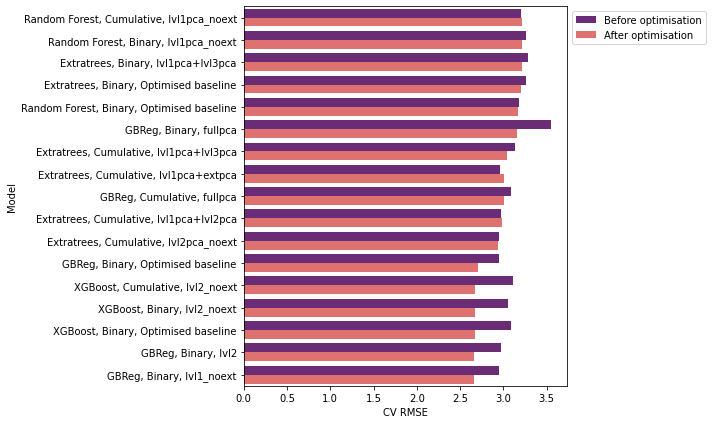

In [179]:
cvimprovement=dict()
cands=["XGBoost","Extratrees","GBReg","Random Forest"]
for cand in cands:
    cvimprovement[cand+", Binary, Optimised baseline"]=(base_scores.loc[cand,"score"],base_reses[cand+"_trao_opt"][0].fun)
for mod, res in reses.items():
    cvimprovement[mod]=(defaultres[mod],res[0].fun)

cvimprovement=pd.DataFrame(cvimprovement).transpose()


cvimprovement.reset_index(inplace=True)
cvimprovement.columns=["Model","Before optimisation","After optimisation"]
winner=cvimprovement[np.min(cvimprovement["After optimisation"])==cvimprovement["After optimisation"]]["Model"].iloc[0]

pattern=r"([a-zA-Z\s]+)_(s?u?ma?x?)_(.+)"
def repl(m):
    if m.group(2)=="sum":
        tex="Cumulative"
    else:
        tex="Binary"
    return "{0}, {1}, {2}".format(m.group(1),tex,m.group(3))
cvimprovement["Model"]=cvimprovement["Model"].str.replace(pattern,repl, regex=True)

cvimprovement=cvimprovement.sort_values(by="After optimisation",ascending=False)
ordering=list(cvimprovement["Model"])
cvimprovement=cvimprovement.melt("Model")
cvimprovement.columns= ["Model","Stage","CV RMSE"]


plt.figure(figsize=(10,6))
cp=sns.barplot(data=cvimprovement,
    x="CV RMSE", y="Model", hue="Stage", palette="magma", order=ordering)
#cp.set_title("Hyperparameter Optimisation results",pad=20)
#ttl.set_position([.5, 1.05])
cp.legend(loc="upper left",bbox_to_anchor=(1, 1))
#cp.axes[0][0].legend(bbox_to_anchor=(1, 1), loc='upper left',legend_out=True)
plt.savefig("Out/Hypoptres.png",dpi=300)
plt.show()

In [183]:
testres = dict()


for cand, res in base_reses.items():
    m=re.search("^([a-zA-Z\s]+)_.+",cand)
    testres["{}, {}, {}".format(m.group(1),"Binary","Optimised baseline")]=evaltest(models3[m.group(1)](**dict(zip(spacenames[m.group(1)],res[0].x))),X_trao,Y_Ext)

    
m=re.search("^([a-zA-Z\s]+)_(s?u?ma?x?)_(.+)",winner)
ismax=False
pattern=r"([a-zA-Z\s]+)_(s?u?ma?x?)_(.+)"
def repl(m):
    if m.group(2)=="sum":
        tex="Cumulative"
    else:
        tex="Binary"
    return "{0}, {1}, {2}".format(m.group(1),tex,m.group(3))
winnername= re.sub(pattern,repl,winner)


if (m.group(2)=="max"): ismax=True
testres[winnername]=evaltest(models3[m.group(1)](**dict(zip(spacenames[m.group(1)],reses[winner][0].x)),random_state=rs),datasets[ismax][m.group(3)],Y_Ext)

In [184]:
testresdf=pd.concat([pd.DataFrame(testres),pd.Series(["MAE","RMSE"],name="Test score")],axis=1).melt("Test score")
testresdf.columns = ["Method","Model","Test Score"]

testresdf

,Method,Model,Test Score
0,MAE,"XGBoost, Binary, Optimised baseline",1.135312
1,RMSE,"XGBoost, Binary, Optimised baseline",2.088811
2,MAE,"Extratrees, Binary, Optimised baseline",1.226119
3,RMSE,"Extratrees, Binary, Optimised baseline",2.231602
4,MAE,"GBReg, Binary, Optimised baseline",1.086769
5,RMSE,"GBReg, Binary, Optimised baseline",2.161057
6,MAE,"Random Forest, Binary, Optimised baseline",1.293092
7,RMSE,"Random Forest, Binary, Optimised baseline",2.741620
8,MAE,"GBReg, Binary, lvl1_noext",1.066995
9,RMSE,"GBReg, Binary, lvl1_noext",1.951475


In [188]:
rcParams["figure.figsize"]

[6.0, 4.0]

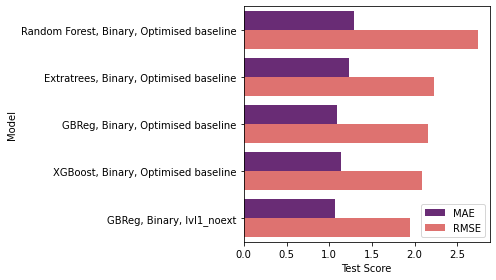

In [196]:
order = list(testresdf[testresdf["Method"]=="RMSE"].sort_values("Test Score",ascending=False)["Model"])

fig=plt.figure(figsize=[7.0,4.0])
ax=sns.barplot(y="Model",x="Test Score",hue="Method",data=testresdf,palette="magma", order=order)
#ax.set_title("Model Test-sample Results",pad=20)
#ttl.set_position([.5, 1.05])

ax.legend(loc="lower right")
plt.savefig("Out/testresults.png",dpi=300)

In [491]:
testresdf

,Method,Model,Test Score
0,MAE,"XGBoost, Binary, Optimised baseline",1.135312
1,RMSE,"XGBoost, Binary, Optimised baseline",2.088811
2,MAE,"Extratrees, Binary, Optimised baseline",1.226119
3,RMSE,"Extratrees, Binary, Optimised baseline",2.231602
4,MAE,"GBReg, Binary, Optimised baseline",1.086769
5,RMSE,"GBReg, Binary, Optimised baseline",2.161057
6,MAE,"Random Forest, Binary, Optimised baseline",1.293092
7,RMSE,"Random Forest, Binary, Optimised baseline",2.741620
8,MAE,"GBReg, Binary, lvl1_noext",1.066995
9,RMSE,"GBReg, Binary, lvl1_noext",1.951475


In [200]:
winnermodel=models3[m.group(1)](**dict(zip(spacenames[m.group(1)],reses[winner][0].x)),random_state=rs)
windata=datasets[1]["lvl1_noext"]
winnermodel.fit(windata.iloc[train_ind],Y_Ext.iloc[train_ind])

GradientBoostingRegressor(alpha=0.7867766671351566,
                          learning_rate=0.06056415372477089, max_depth=5,
                          max_features=4, min_samples_split=4, n_estimators=576,
                          random_state=42, subsample=0.9326676834240688)

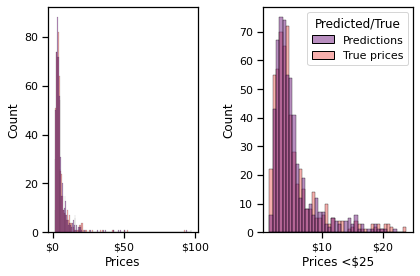

In [490]:
ypreds=winnermodel.predict(windata.iloc[test_ind])
ytrue=Y_Ext.iloc[test_ind]
ytrue.name="ytrue"
diffs=pd.concat([pd.Series(ypreds,name="ypred"),ytrue],axis=1)
diffs["diff"]=diffs["ytrue"]-diffs["ypred"]
predictions=pd.concat([pd.Series(ypreds,name="Predictions"),ytrue.rename("True prices",axis=1)],axis=1).melt()
predictions.columns=["Predicted/True","Prices"]
fig,axs=plt.subplots(ncols=2)
sns.histplot(data=predictions, x="Prices",hue="Predicted/True",palette="magma",ax=axs[0],legend=False)
sns.histplot(predictions[predictions["Prices"]<25].rename({"Prices":"Prices <\$25"},axis=1), x="Prices <\$25",hue="Predicted/True",palette="magma",ax=axs[1])
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: "$"+ "{}".format(int(x))))
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: "$"+ "{}".format(int(x))))
plt.savefig("preddist.png",dpi=300)

In [243]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
score = make_scorer((lambda true,pred:mean_squared_error(true,pred,squared=False)),greater_is_better=False)
permimp=permutation_importance(winnermodel,windata.iloc[test_ind],Y_Ext.iloc[test_ind],scoring=score,n_repeats=15,n_jobs=3,random_state=rs)


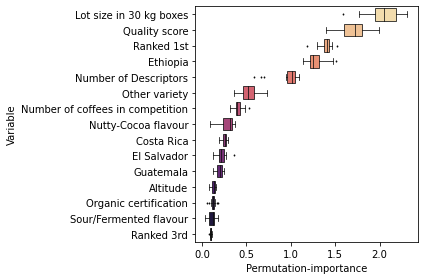

In [244]:
sorted_idx = permimp.importances_mean.argsort()

#fig, ax = plt.subplots()
#sns.boxplot(permimp)
permimp
impdf=pd.DataFrame(permimp["importances"]).transpose()
impdf.columns=windata.columns
impdf=impdf.melt()
impdf.columns=["Variable","Permutation-importance"]
order=impdf.groupby("Variable").mean("Permutation-importance").sort_values(by="Permutation-importance",ascending=False).index
vardict= {"fin_size":"Lot size in 30 kg boxes",
          "score":"Quality score",
          "rank1":"Ranked 1st",
          "country__Ethiopia":"Ethiopia",
          "numDesc":"Number of Descriptors",
          "other_variety":"Other variety",
          "ncoff":"Number of coffees in competition",
          "country__Costa Rica":"Costa Rica",
          "Nutty...cocoa_lvl1":"Nutty-Cocoa flavour",
          "country__Guatemala":"Guatemala",
          "country__El Salvador":"El Salvador",
          "altitude":"Altitude",
          "organic":"Organic certification",
          "Sour...fermented_lvl1":"Sour/Fermented flavour",
          "rank3":"Ranked 3rd"}

impdf["Variable"]=impdf["Variable"].replace(vardict)
order=impdf.groupby("Variable").mean("Permutation-importance").sort_values(by="Permutation-importance",ascending=False).index

sns.boxplot(data=impdf,y="Variable",x="Permutation-importance",order=order[0:15],palette="magma_r",linewidth=0.75,fliersize=1)
plt.savefig("Out/feature-imps.png",dpi=300)

In [316]:
winnermodelfullsample=models3[m.group(1)](**dict(zip(spacenames[m.group(1)],reses[winner][0].x)),random_state=rs)
windata=datasets[1]["lvl1_noext"]
winnermodelfullsample.fit(windata,Y_Ext)
scaledback=pd.DataFrame(winscaler.inverse_transform(windata))
scaledback.columns=windata.columns
scaledback=scaledback.rename(vardict,axis=1)

In [262]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scale down",winscaler),("model",winnermodelfullsample)])

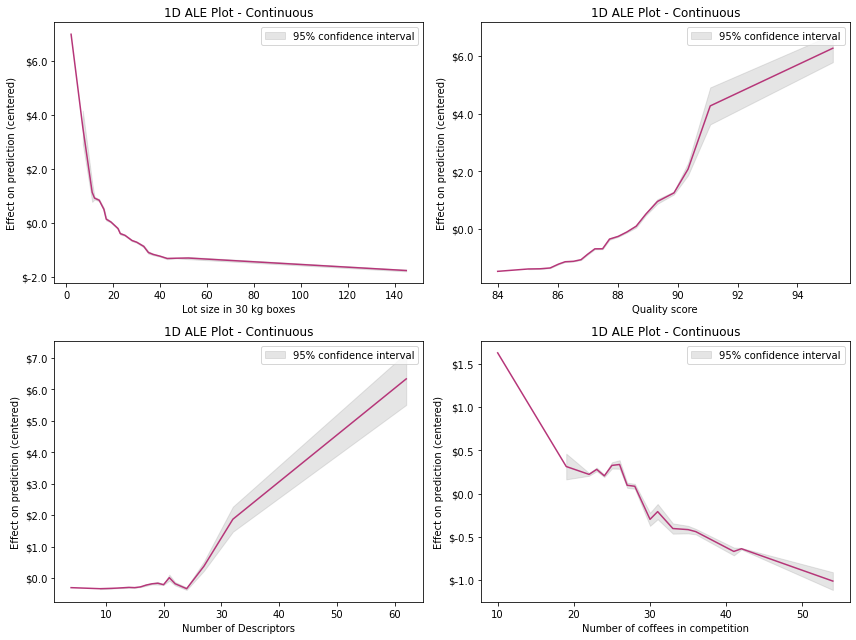

In [325]:
from PyALE import ale
import matplotlib.ticker as ticker
fig,[[axs1,axs2],[axs3,axs4]] = plt.subplots(2,2,figsize=(12,9))
ale_res_1 = ale(
    X=scaledback,
    model=pipe,
    feature=["Lot size in 30 kg boxes"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=axs1
)
ale_res_2 = ale(
    X=scaledback,
    model=pipe,
    feature=["Quality score"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=axs2
)
ale_res_3 = ale(
    X=scaledback,
    model=pipe,
    feature=["Number of Descriptors"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=axs3
)
ale_res_4 = ale(
    X=scaledback,
    model=pipe,
    feature=["Number of coffees in competition"],
    feature_type="continuous",
    grid_size=20,
    include_CI=True,
    C=0.95,
    plot=True,
    fig=fig,
    ax=axs4
)

axs1.title
for ax in plt.gcf().axes:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: "$"+ "{}".format(x)))
    ax.get_lines()[0].set_color("#B63679FF")
    ax.get_children()[-12].remove()
plt.savefig("Out/ALEcont.png",dpi=300)

In [382]:
ranksintact = scaledback.drop(["Ranked 1st", "Ranked 3rd","rank4","rank2"], axis=1, inplace=False).copy()
ranksintact = pd.concat([ranksintact,traore_data["rank"]],axis=1)
ranksintact["rank"]=ranksintact["rank"].str.extract("(\d+)").astype(int)
ranksintact.loc[ranksintact["rank"]>4,"rank"]=0


0    2374
1     137
2     134
3     127
4     117
Name: rank, dtype: int64

In [393]:
def encoderanksfull(df):
    dummies=pd.get_dummies(df["rank"],prefix="rank")
    dummies=dummies.drop("rank_0",axis=1)
    dummies.columns=["Ranked 1st","rank2","Ranked 3rd","rank4"]
    fin=pd.concat([df.drop("rank",axis=1),dummies],axis=1)
    return fin


0       0
1       1
2       0
3       0
4       0
       ..
2884    0
2885    0
2886    0
2887    0
2888    0
Name: rank2, Length: 2889, dtype: uint8

<ipython-input-457-73d760e181b4>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


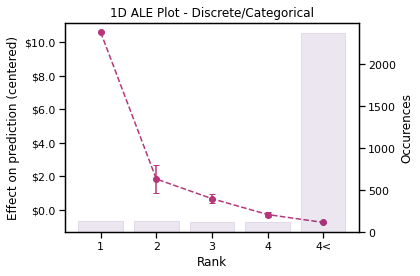

In [457]:
fig,ax=plt.subplots()
ale_ranks = ale(
    X=ranksintact,
    model=pipe,
    feature=["rank"],
    feature_type="categorical",
    grid_size=20,
    encode_fun=encoderanksfull,
    include_CI=True,
    C=0.95,
    plot=True,
    predictors=list(scaledback.columns),
    fig=fig,
    ax=ax
)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: "$"+ "{}".format(x)))
ax.get_lines()[0].set_color("#B63679FF")
ax.get_lines()[1].set_color("#B63679FF")
ax.get_lines()[2].set_color("#B63679FF")
ax.get_children()[0].set_color("#B63679FF")

ax2=plt.gca()
for rect in ax2.get_children()[0:5]:
    rect.set_color("#3B0F70FF")
ax2.tick_params(axis="y",color="black",which="both")
[t.set_color('black') for t in ax2.yaxis.get_ticklabels()]
ax2.yaxis.label.set_color('black')
ax2.set_ylabel("Occurences")
ax.set_xlabel("Rank")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-1] = '4<'
ax.set_xticklabels(labels)
plt.savefig("ranks.png",dpi=300)